In [91]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import cross_validate  #Run cross-validation for single metric evaluation.
from sklearn.metrics import accuracy_score  
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import plot_roc_curve, auc, roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree



In [92]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [93]:
# # select just object columns
# df.select_dtypes(include='object')
# # select multiple data types
# df.select_dtypes(include=['int', 'datetime', 'object'])
# # exclude certain data types
# df.select_dtypes(exclude='int')

In [94]:
#categorize numerical feature
# import sys
# df['ageGroup']=pd.cut(
#     df['Age'], 
#     bins=[0, 13, 19, 61, sys.maxsize], 
#     labels=['<12', 'Teen', 'Adult', 'Older']
# )

In [95]:
#When the DataFrame is already created, we can use pandas replace() function to handle these values:
#df_clean = df.replace({ "?": np.nan, "&": np.nan })

In [96]:
# #Interaction terms are extra features that result from the product of two existing features.

# X = pd.DataFrame({
#       'a':[1.0, 2.0, 3.0],
#       'b':[1.0, 2.0, 0.0]})
# m = PolynomialFeatures(interaction_only=True)
# m.fit_transform(X)

In [97]:
# #from string to int, Nan when the values are not numbers
# df['sales'] = pd.to_numeric(df['sales'], errors='coerce')

# #To drop columns in which more than 10% of values are missing
# df.dropna(thresh=len(df)*0.9, axis=1)

In [98]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

df_train.head()

df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [ ]:
sns.pairplot(df_train, hue="Survived")


In [ ]:
sns.heatmap(df_train[['Fare','Age','SibSp','Parch','Survived']].corr().abs(), annot=True)

In [ ]:
sns.scatterplot(data=df_train, x="Parch", y='SibSp', hue="Survived")


In [ ]:
titles = set()
for name in df_test['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())
for name in df_train['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())

print(titles)


In [99]:

Title_dict = {'Capt':'Officer',
 'Col':'Officer',
 'Don': 'Royalty',
 'Dr':'Officer',
 'Dona':'Mrs',
 'Jonkheer':'Royalty',
 'Lady':'Royalty',
 'Major': 'Officer',
 'Master':'Master',
 'Miss':'Miss',
 'Mlle':'Miss',
 'Mme':'Mrs',
 'Mr':'Mr',
 'Mrs':'Mrs',
 'Ms':'Miss',
 'Rev':'Officer',
 'Sir':'Royalty',
 'the Countess':'Royalty'}

def feature_eng(df):
    df['Sex'] = (df['Sex'] == 'male').astype(int)    
    df['Age'] = df.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.mean()))
    df['Fare'] = df.groupby(['Pclass','Sex'])['Fare'].transform(lambda x: x.fillna(x.median()))
    df.dropna(axis=0, subset=['Embarked'], inplace=True)
    df['Title'] = df['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())
    df['Title'] = df.Title.map(Title_dict)
    df['Family_Size'] = df['SibSp']+df['Parch']
    df['Age*Class'] = df['Age']*df['Pclass']
    df['Fare_Per_Person'] = df['Fare']/(df['Family_Size']+1)
    df.drop(columns=['Name','Age','Fare','SibSp','Parch','Pclass','Cabin','Ticket'], inplace=True)
    return df



df_train = feature_eng(df_train)
df_test = feature_eng(df_test)




In [ ]:
df_train.head()

In [ ]:
sns.heatmap(df_train[['Fare_Per_Person','Age*Class','Sex','Family_Size','Survived']].corr().abs(), annot=True)

In [ ]:
sns.scatterplot(x='Fare_Per_Person', y='Age*Class', hue='Survived',data=df_train)


In [ ]:
df_train.info()
df_test.info()

In [100]:
# feature engineering for numericals
numeric_features = ["Age*Class", 'Fare_Per_Person', 'Family_Size']

# create a sequential pipeline 
# output of one step will be input to the next 
numeric_transformer = make_pipeline( RobustScaler(),
    PolynomialFeatures(interaction_only=True),
    # StandardScaler(),
    KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    )

# feature engineering for categorical
categorical_features = ["Embarked",'Title']

# handle unknown means it will ignore nan's if it finds them
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# you can also create custom functions
# def name_length(df):
#     length = df[df.columns[0]].str.len()
#     return length.values.reshape(-1, 1)

# pre-process transformations
# notice here that we include a pipeline for the numeric transformations

# Columns of the original feature matrix that are not specified are dropped 
# from the resulting transformed feature matrix, unless specified in the 
# passthrough keyword

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        # ('name', FunctionTransformer(name_length), ['Name']),
    ],
    remainder='passthrough')

# create the model pipeline
pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=300, solver='liblinear', penalty='l1'))
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(max_depth=5))


In [101]:
X = df_train.drop(columns='Survived')
y = df_train['Survived']

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=13)


In [ ]:
X_train.columns

In [103]:
pipe_rf.fit(X_train, y_train)

/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(interaction_only=True)),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    strategy='uniform'))]),
                                                  ['Age*Class',
                                                   'Fare_Per_Person',
                                               

In [104]:
pipe_rf.score(X_train, y_train)

0.8354430379746836

In [105]:
pipe_rf.score(X_test, y_test)

0.8370786516853933

In [106]:
pipeline.fit(X_train, y_train)

/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures(interaction_only=True)),
                                                                  ('kbinsdiscretizer',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    strategy='uniform'))]),
                                                  ['Age*Class',
                                                   'Fare_Per_Person',
                                               

In [107]:
pipeline.score(X_train, y_train)

0.8368495077355836

In [108]:
pipeline.score(X_test, y_test)

0.8146067415730337

In [109]:
pipe_rf.score(X_test, y_test)

0.8370786516853933

In [110]:
cv = cross_validate(pipeline, X_train, y_train,
                    cv=5,
                    scoring='accuracy',
                    return_train_score=True
)
# convert the dictionary of lists into a DataFrame
cv = pd.DataFrame(cv)
print(cv)

/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "


   fit_time  score_time  test_score  train_score
0  0.033236    0.015869    0.825175     0.834507
1  0.052540    0.019300    0.823944     0.834798
2  0.050720    0.020483    0.852113     0.826011
3  0.030163    0.011577    0.802817     0.841828
4  0.031680    0.013063    0.816901     0.840070


/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "


In [111]:
cv_r = cross_validate(pipeline, X_train, y_train,
                    cv=5,
                    scoring='recall',
                    return_train_score=True
)
# convert the dictionary of lists into a DataFrame
cv_r = pd.DataFrame(cv_r)
print(cv_r)

/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "


   fit_time  score_time  test_score  train_score
0  0.032423    0.014047    0.814815     0.708920
1  0.035849    0.025951    0.703704     0.723005
2  0.046791    0.029418    0.735849     0.742991
3  0.039126    0.012560    0.679245     0.761682
4  0.029063    0.011627    0.716981     0.738318


/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "


In [112]:
cv_rf = cross_validate(pipe_rf, X_train, y_train,
                    cv=5,
                    scoring='accuracy',
                    return_train_score=True
)
# convert the dictionary of lists into a DataFrame
cv_rf = pd.DataFrame(cv_rf)
print(cv_rf)

/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Featu

   fit_time  score_time  test_score  train_score
0  0.540470    0.043005    0.832168     0.843310
1  0.301556    0.032697    0.816901     0.838313
2  0.344906    0.045582    0.873239     0.836555
3  0.348709    0.028965    0.760563     0.857645
4  0.338198    0.033824    0.816901     0.841828


In [113]:
cv_r_rf = cross_validate(pipe_rf, X_train, y_train,
                    cv=5,
                    scoring='recall',
                    return_train_score=True
)
# convert the dictionary of lists into a DataFrame
cv_r_rf = pd.DataFrame(cv_r_rf)
print(cv_r_rf)

/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
/Users/stefan/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:187: UserWarning: Featu

   fit_time  score_time  test_score  train_score
0  0.362331    0.042729    0.814815     0.760563
1  0.359086    0.030570    0.722222     0.765258
2  0.329152    0.070082    0.773585     0.766355
3  0.459254    0.033538    0.660377     0.789720
4  0.271555    0.029487    0.735849     0.761682


In [114]:

# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
# from sklearn.ensemble import VotingClassifier

# models = [
#           ('logreg', LogisticRegression()),
#           ('tree', DecisionTreeClassifier()),
#           ('svm', SVC(kernel='rbf'))
# ]
# m = VotingClassifier(models)

# m.fit(X, y)
# m.score(X, y)

In [115]:
y_pred = pipeline.predict(X_test)
pipeline.score(X_test,y_test) 

0.8146067415730337

In [116]:
y_pred_rf = pipe_rf.predict(X_test)
pipe_rf.score(X_test, y_test)

0.8370786516853933

Precision:  0.8703703703703703  Recall:  0.6438356164383562


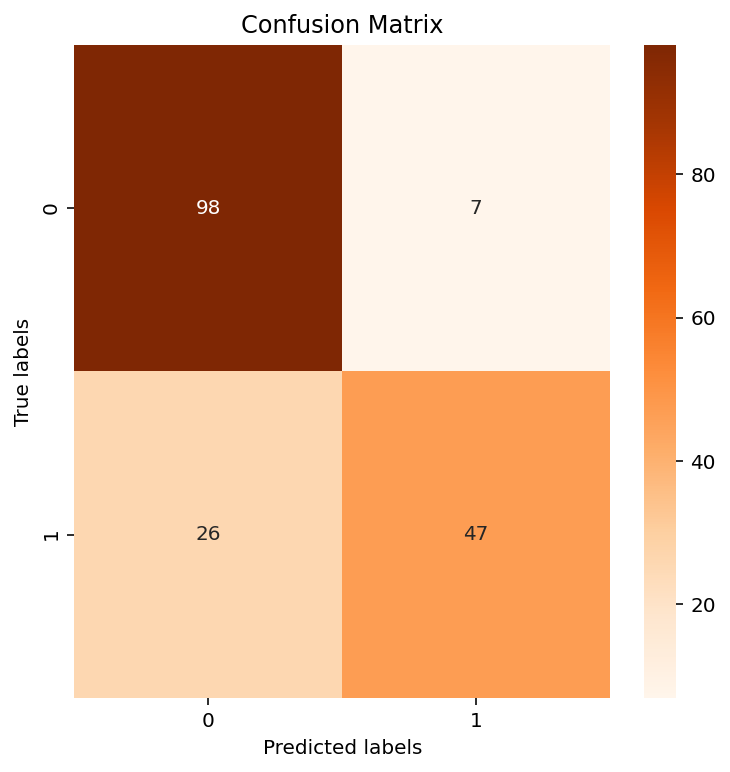

In [117]:
print('Precision: ',precision_score(y_test,y_pred), ' Recall: ', recall_score(y_test,y_pred))
    
conf = confusion_matrix(y_test, y_pred)
#plot the heatmap
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot()
sns.heatmap(conf, annot=True, ax = ax, fmt='g', cmap = 'Oranges')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

Precision:  0.8793103448275862  Recall:  0.6986301369863014


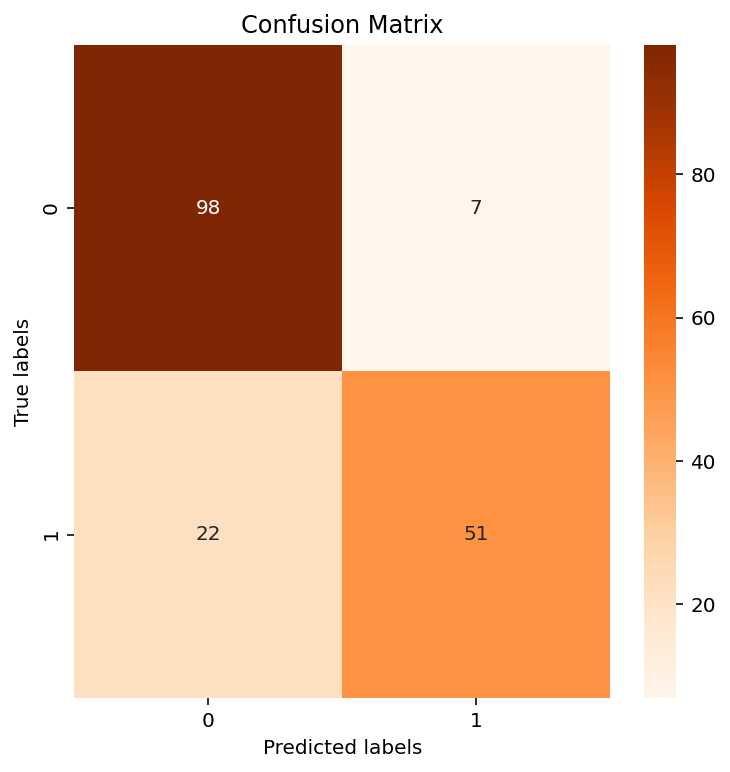

In [118]:
print('Precision: ',precision_score(y_test,y_pred_rf), ' Recall: ', recall_score(y_test,y_pred_rf))
    
conf = confusion_matrix(y_test, y_pred_rf)
#plot the heatmap
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot()
sns.heatmap(conf, annot=True, ax = ax, fmt='g', cmap = 'Oranges')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

In [119]:
predict = pipe_rf.predict(df_test)

In [120]:
df_test.head()

,PassengerId,Sex,Embarked,Title,Family_Size,Age*Class,Fare_Per_Person
0,892,1,Q,Mr,0,103.5,7.829200
1,893,0,S,Mrs,1,141.0,3.500000
2,894,1,Q,Mr,0,124.0,9.687500
3,895,1,S,Mr,0,81.0,8.662500
4,896,0,S,Mrs,2,66.0,4.095833


In [121]:
#modify threshold
#Adding votingclassifier to pipeline

output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': predict})
output.to_csv('my_submission4.csv', index=False)
print("Submission saved")

Submission saved
